<a href="https://colab.research.google.com/github/mamekra/match-your-mood-to-your-music/blob/main/gru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import joblib
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

GPU is available


In [2]:
# Set mixed precision policy
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

# Load data
DATA_PATH = 'labeled_songs.csv'
data = pd.read_csv(DATA_PATH)

# Extract cleaned lyrics and emotion labels
lyrics = data['cleaned_lyrics']
emotions = data['emotion']

In [3]:
# Encode emotions
emotion_classes = sorted(emotions.unique())
emotion_to_int = {emotion: i for i, emotion in enumerate(emotion_classes)}
data['emotion_encoded'] = data['emotion'].map(emotion_to_int)



In [4]:
# Tokenize lyrics
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(lyrics)
sequences = tokenizer.texts_to_sequences(lyrics)



In [5]:

# Pad sequences
max_sequence_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# Prepare labels
labels = to_categorical(data['emotion_encoded'], num_classes=len(emotion_classes))



In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=42
)




In [7]:
from tensorflow.keras.layers import GRU, Bidirectional, Dropout, Dense, Embedding
from tensorflow.keras.models import Sequential

embedding_dim = 64

from tensorflow.keras.regularizers import l2

model = Sequential([
    Embedding(input_dim=10000, output_dim=embedding_dim, input_length=max_sequence_length),
    GRU(64),
    Dropout(0.2),
    Dense(len(emotion_classes), activation='softmax')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [8]:

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [9]:
# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=8,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)


Epoch 1/15
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 103s 9ms/step - accuracy: 0.6704 - loss: 0.8672 - val_accuracy: 0.7530 - val_loss: 0.6541
Epoch 2/15
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 136s 10ms/step - accuracy: 0.7641 - loss: 0.6198 - val_accuracy: 0.7571 - val_loss: 0.6311
Epoch 3/15
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 140s 9ms/step - accuracy: 0.7847 - loss: 0.5570 - val_accuracy: 0.7538 - val_loss: 0.6304
Epoch 4/15
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 95s 10ms/step - accuracy: 0.7977 - loss: 0.5111 - val_accuracy: 0.7487 - val_loss: 0.6506
Epoch 5/15
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 143s 10ms/step - accuracy: 0.8131 - loss: 0.4707 - val_accuracy: 0.7473 - val_loss: 0.6685
Epoch 6/15
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 138s 9ms/step - accuracy: 0.8297 - loss: 0.4317 - val_accuracy: 0.7423 - val_loss: 0.6981


In [10]:
# Evaluate the model
results = model.evaluate(X_val, y_val)
print(f"Validation Loss: {results[0]}, Validation Accuracy: {results[1]}")




625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7524 - loss: 0.6308
Validation Loss: 0.6303509473800659, Validation Accuracy: 0.7537999749183655


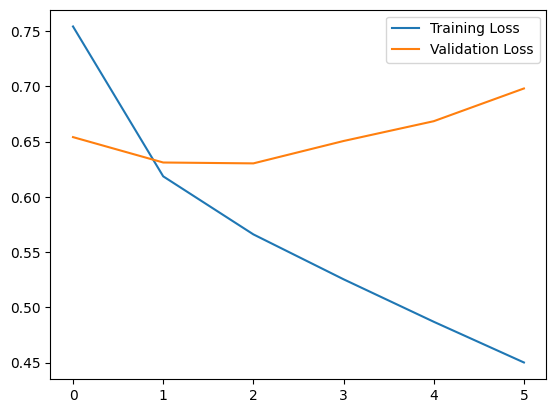

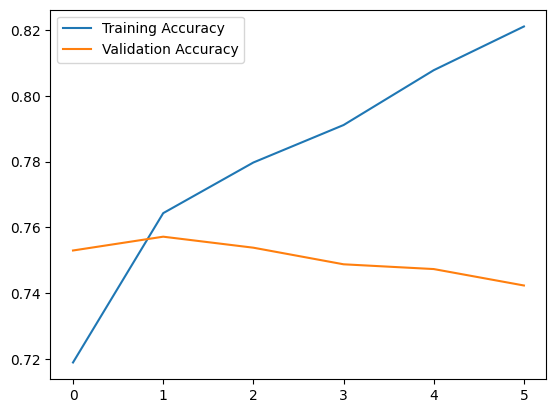

In [11]:
# Plot training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


model.save('lstm_emotion_model.h5')

In [12]:
def recommend_song(emotion, model, tokenizer, data, emotion_to_int):
    """
    Recommend a song based on the given emotion.
    """
    emotion_index = emotion_to_int.get(emotion)
    if emotion_index is None:
        return f"Emotion '{emotion}' not recognized."

    # Filter songs with the given emotion
    matching_songs = data[data['emotion_encoded'] == emotion_index]
    if matching_songs.empty:
        return f"No songs found for emotion '{emotion}'."

    # Randomly pick a matching song
    song = matching_songs.sample(1).iloc[0]
    return f"Recommended song: {song['title']} by {song['artist']}"





In [13]:

# Test recommendation
print(recommend_song('anger', model, tokenizer, data, emotion_to_int))

Recommended song: Gibberish Rap by Hannibal Buress


In [14]:
model.save('gru_emotion_model.h5')